# Desafio Indicium

1.Utilizando as variáveis (features), faça um relatório com uma análise das principais estatísticas da base de dados. Descreva graficamente essas variáveis (features), apresentando as suas principais estatísticas descritivas. Comente o porquê da escolha destas estatísticas e o que elas nos informam.

2.Faça uma EDA. Nesta EDA, crie e responda 3 hipóteses de negócio. Além disso,  responda também às seguintes perguntas de negócio:

a Qual o melhor estado cadastrado na base de dados para se vender um carro de marca popular e por quê?
b Qual o melhor estado para se comprar uma picape com transmissão automática e por quê?
c Qual o melhor estado para se comprar carros que ainda estejam dentro da garantia de fábrica e por quê?

3.Explique como você faria a previsão do preço a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?


## Validação dos dados     

Esse banco de dados tem 29584 linhas e 29 colunas. Devido a quantidade de nulos em algumas colunas optei por algumas alterações após a validação.

# Importando bibliotecas

In [56]:
# Bibliotecas padrão
import re
import chardet

# Manipulação e análise de dados
import pandas as pd
import numpy as np

# Visualização
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

# Aprendizado de máquina
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import statsmodels.api as sm

# Configurações
pd.set_option('display.max_columns', None)

# Funções utilitárias
def nome_para_sigla(estado):
    mapa_estados = {
        'Acre': 'AC', 'Alagoas': 'AL', 'Amapá': 'AP', 'Amazonas': 'AM', 'Bahia': 'BA',
        'Ceará': 'CE', 'Distrito Federal': 'DF', 'Espírito Santo': 'ES', 'Goiás': 'GO',
        'Maranhão': 'MA', 'Mato Grosso': 'MT', 'Mato Grosso do Sul': 'MS', 'Minas Gerais': 'MG',
        'Pará': 'PA', 'Paraíba': 'PB', 'Paraná': 'PR', 'Pernambuco': 'PE', 'Piauí': 'PI',
        'Rio de Janeiro': 'RJ', 'Rio Grande do Norte': 'RN', 'Rio Grande do Sul': 'RS', 'Rondônia': 'RO',
        'Roraima': 'RR', 'Santa Catarina': 'SC', 'São Paulo': 'SP', 'Sergipe': 'SE', 'Tocantins': 'TO'
    }
    return mapa_estados.get(estado, estado)

def evaluate_model(X, y, model, name, cv=5):
    pipeline = make_pipeline(SimpleImputer(strategy='median'), model)
    scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring)
    return {f'{name}_{k}': v for k, v in scores.items()}

def capacidade_motor_cilindradas(texto):
    match = re.search(r'[0-9]+\.[0-9]+', texto)

    if match:
        primeiro_float = float(match.group())
        return primeiro_float
    else:
        return np.nan
    
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2., height,
                '%d' % int(height),
                ha='center', va='bottom')

def process_column(df, col_name, mapping_dict):
    print(df[col_name].value_counts())
    df[col_name] = df[col_name].fillna('nao')
    df[col_name] = df[col_name].map(mapping_dict)
    print(df[col_name].value_counts())

def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
    return result['encoding']

def capacidade_motor_valvulas(texto):
    texto = texto.lower()
    """Extrai o número imediatamente antes de um 'v' em uma string"""
    match = re.search(r'[0-9]+(?=v)', texto)

    if match:
        primeiro_numero_v = match.group()
        return primeiro_numero_v
    else:
        return np.nan
    
def extract_fuel_type(car_model):
    car_model = car_model.upper()
    if re.search(r"FLEX", car_model):
        return "Flex"
    elif re.search(r"ÁLCOOL|ALCOOL", car_model):
        return "Alcool"
    elif re.search(r"DIESEL", car_model):
        return "Diesel"
    elif re.search(r"GASOLINA|TFSI|INGENIUM|SUPERCHARGED|TWIN POWER|SPORTBACK|SVR", car_model):
        return "Gasolina"
    elif re.search(r"ETANOL", car_model):
        return "Etanol"
    elif re.search(r"HYBRID|HÍBRIDO|RECHARGE|TIPTRONIC", car_model):
        return "Híbrido"
    elif re.search(r"ELECTRIC|ELÉTRICO|BEV", car_model):
        return "Elétrico"
    elif re.search(r"GAS", car_model):
        return "GNV"
    elif re.search(r"TETRAFUEL", car_model):
        return "Tetrafuel"
    elif re.search(r"TSI", car_model):
        return "Flex"
    else:
        return "Não identificado"

## Importando a base de dados

In [2]:
file_path = '/home/bloom/Downloads/cars_train.csv'  
encoding = detect_encoding(file_path)

print(f'The encoding of the file is: {encoding}')

The encoding of the file is: UTF-16


In [3]:
treino = pd.read_csv('/home/bloom/Downloads/cars_train.csv', delimiter='\t', encoding='utf-16')
teste = pd.read_csv('/home/bloom/Downloads/cars_test.csv', delimiter='\t', encoding='utf-16')

### Análise descritiva

In [4]:
treino.describe()

num_fotos  ano_de_fabricacao    ano_modelo      hodometro  \
count  29407.000000       29584.000000  29584.000000   29584.000000   
mean      10.323834        2016.758552   2017.808985   58430.592077   
std        3.487334           4.062422      2.673930   32561.769309   
min        8.000000        1985.000000   1997.000000     100.000000   
25%        8.000000        2015.000000   2016.000000   31214.000000   
50%        8.000000        2018.000000   2018.000000   57434.000000   
75%       14.000000        2019.000000   2020.000000   81953.500000   
max       21.000000        2022.000000   2023.000000  390065.000000   

         num_portas  veiculo_alienado         preco  
count  29584.000000               0.0  2.958400e+04  
mean       3.940677               NaN  1.330239e+05  
std        0.338360               NaN  8.166287e+04  
min        2.000000               NaN  9.869951e+03  
25%        4.000000               NaN  7.657177e+04  
50%        4.000000               NaN  1.143558e+05  
75%        4.000000               NaN  1.636796e+05  
max        4.000000               NaN  1.359813e+06

1. **Quantidade de Dados (`count`)**:
   - A maior parte das colunas tem 29.584 entradas. Contudo, a coluna `num_fotos` possui apenas 29.407 entradas, indicando que alguns veículos podem não ter informações sobre o número de fotos.

2. **Num_fotos**:
   - Média de 10,32 fotos por veículo.
   - Varia entre um mínimo de 8 fotos e um máximo de 21.
   - 50% dos veículos (mediana) têm 8 fotos, mas há veículos (75% quartil) com até 14 fotos.

3. **Ano_de_fabricacao**:
   - Média de fabricação dos veículos é 2016.
   - O veículo mais antigo é de 1985 e o mais recente de 2022.
   - 50% dos veículos foram fabricados até 2018.

4. **Hodômetro**:
   - Em média, os veículos rodaram 58.430 km.
   - Há veículos com apenas 100 km e outros com até 390.065 km.

5. **Num_portas**:
   - Em média, os veículos possuem cerca de 4 portas.
   - Varia entre 2 e 4 portas.
   - 75% dos veículos têm 4 portas.

6. **Dono_aceita_troca**:
   - 74% dos proprietários aceitam trocas.

7. **Veiculo_único_dono**:
   - 35% dos veículos tiveram apenas um dono.

8. **Revisoes_concessionaria**:
   - 31% dos veículos tiveram suas revisões feitas em concessionárias.

9. **Ipva_pago**:
   - 66% dos veículos estão com o IPVA pago.

10. **Veiculo_licenciado**:
    - 54% dos veículos estão licenciados.

11. **Garantia_de_fábrica**:
    - Apenas 15% dos veículos ainda possuem garantia de fábrica.

12. **Revisoes_dentro_agenda**:
    - 20% dos veículos tiveram suas revisões feitas dentro da agenda recomendada.

13. **Veiculo_alienado**:
    - Parece que nenhum veículo da lista está alienado (valor máximo e média são 0).

14. **Preço**:
    - O preço médio dos veículos é aproximadamente 133.024 unidades monetárias (presumindo que seja em reais ou outra moeda).
    - Há veículos tão baratos quanto cerca de 9.870 e outros tão caros quanto 1.359.813.

**Conclusão**:
Os dados parecem descrever uma variedade de veículos, desde os mais antigos até os mais recentes, com diferentes históricos de uso e condições. A maioria dos veículos é mais recente (pós-2015), tem 4 portas, e rodou uma quantidade moderada de km. Além disso, a maior parte dos proprietários aceita trocas, mas apenas uma pequena porcentagem dos veículos ainda possui garantia de fábrica.

In [5]:
print("Informações sobre o DataFrame 'treino':")
print("--------------------------------------")
treino.info()

print("\nValores nulos por coluna:")
print("-------------------------")
print(treino.isna().sum())

print("\nPercentual de valores nulos por coluna:")
print("---------------------------------------")
percentual_nulos = treino.isnull().mean() * 100
print(percentual_nulos)

Informações sobre o DataFrame 'treino':
--------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29584 entries, 0 to 29583
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       29584 non-null  object 
 1   num_fotos                29407 non-null  float64
 2   marca                    29584 non-null  object 
 3   modelo                   29584 non-null  object 
 4   versao                   29584 non-null  object 
 5   ano_de_fabricacao        29584 non-null  int64  
 6   ano_modelo               29584 non-null  float64
 7   hodometro                29584 non-null  float64
 8   cambio                   29584 non-null  object 
 9   num_portas               29584 non-null  int64  
 10  tipo                     29584 non-null  object 
 11  blindado                 29584 non-null  object 
 12  cor                      29584 non-null  object 
 1

In [6]:
teste.describe()

num_fotos  ano_de_fabricacao   ano_modelo      hodometro  \
count  9802.000000        9862.000000  9862.000000    9862.000000   
mean     10.323811        2016.716893  2017.801663   58237.207057   
std       3.462367           4.151105     2.679667   32487.018991   
min       8.000000        1988.000000  2007.000000     100.000000   
25%       8.000000        2015.000000  2016.000000   31323.250000   
50%       8.000000        2018.000000  2018.000000   56742.000000   
75%      14.000000        2019.000000  2020.000000   81784.000000   
max      21.000000        2022.000000  2023.000000  381728.000000   

        num_portas  veiculo_alienado  
count  9862.000000               0.0  
mean      3.942507               NaN  
std       0.333749               NaN  
min       2.000000               NaN  
25%       4.000000               NaN  
50%       4.000000               NaN  
75%       4.000000               NaN  
max       4.000000               NaN

1. **num_fotos**:
   - Varia de 8 a 21 fotos.
   - A maioria dos veículos tem 8 fotos (50% dos veículos, mediana).
   - Em média, os veículos têm aproximadamente 10,32 fotos.
   - Há uma variação (desvio padrão) de cerca de 3,46 no número de fotos por veículo.

2. **ano_de_fabricacao**:
   - Os veículos foram fabricados entre 1988 e 2022.
   - A mediana do ano de fabricação é 2018, ou seja, 50% dos veículos foram fabricados em 2018 ou depois.
   - Em média, os veículos foram fabricados em 2016,7 (aproximadamente).

3. **ano_modelo**:
   - Os modelos dos veículos variam de 2007 a 2023.
   - Em média, o ano do modelo é aproximadamente 2017,8.
   - Metade dos veículos têm 2018 como ano do modelo.

4. **hodometro**:
   - A quilometragem varia de apenas 100 km a 381.728 km.
   - A mediana da quilometragem é de 56.742 km.
   - Em média, os veículos rodaram aproximadamente 58.237 km.

5. **num_portas**:
   - Os veículos têm entre 2 e 4 portas.
   - A grande maioria (75% ou mais) tem 4 portas.

6. **dono_aceita_troca**:
   - 74,1% dos proprietários aceitam troca (valor médio de 0,741).
   
7. **veiculo_único_dono**:
   - 35,2% dos veículos tiveram apenas um único dono.
   
8. **revisoes_concessionaria**:
   - Apenas 31% dos veículos tiveram suas revisões feitas na concessionária.

9. **ipva_pago**:
   - 66,6% dos veículos estão com o IPVA pago.

10. **veiculo_licenciado**:
    - 54,2% dos veículos estão licenciados.

11. **garantia_de_fábrica**:
    - Apenas 14,4% dos veículos ainda possuem garantia de fábrica.

12. **revisoes_dentro_agenda**:
    - 20,2% dos veículos tiveram suas revisões realizadas dentro da agenda recomendada.

13. **veiculo_alienado**:
    - Nenhum veículo é alienado (todos têm valor 0 para essa característica).

**Conclusões**:
A maioria dos veículos nesta tabela têm 4 portas, com uma mediana de 56.742 km rodados. A maioria foi fabricada recentemente, com uma mediana no ano de 2018. Enquanto muitos proprietários aceitam trocas (74,1%), apenas uma pequena porcentagem dos veículos ainda possui garantia de fábrica ou fez revisões na concessionária. A maioria dos veículos está com o IPVA pago e está licenciada. Além disso, é interessante notar que nenhum veículo é alienado.

In [7]:
print("Informações sobre o DataFrame 'treino':")
print("--------------------------------------")
teste.info()

print("\nValores nulos por coluna:")
print("-------------------------")
print(teste.isna().sum())

print("\nPercentual de valores nulos por coluna:")
print("---------------------------------------")
percentual_nulos = teste.isnull().mean() * 100
print(percentual_nulos)

Informações sobre o DataFrame 'treino':
--------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9862 entries, 0 to 9861
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       9862 non-null   object 
 1   num_fotos                9802 non-null   float64
 2   marca                    9862 non-null   object 
 3   modelo                   9862 non-null   object 
 4   versao                   9862 non-null   object 
 5   ano_de_fabricacao        9862 non-null   int64  
 6   ano_modelo               9862 non-null   float64
 7   hodometro                9862 non-null   float64
 8   cambio                   9862 non-null   object 
 9   num_portas               9862 non-null   int64  
 10  tipo                     9862 non-null   object 
 11  blindado                 9862 non-null   object 
 12  cor                      9862 non-null   object 
 13 

## Tratamento de dados nulos

In [8]:
mappings = {
    'veiculo_licenciado': {'Licenciado': 1, 'nao': 0},
    'ipva_pago': {'IPVA pago': 1, 'nao': 0},
    'dono_aceita_troca': {'Aceita troca': 1, 'nao': 0},
    'garantia_de_fábrica': {'Garantia de fábrica': 1, 'nao': 0},
    'veiculo_único_dono': {'Único dono': 1, 'nao': 0},
    'revisoes_concessionaria': {'Todas as revisões feitas pela concessionária': 1, 'nao': 0},
    'revisoes_dentro_agenda': {'Todas as revisões feitas pela agenda do carro': 1, 'nao': 0},
    'veiculo_alienado': {'Sim': 1, 'nao': 0},
}

for col, map_dict in mappings.items():
    process_column(treino, col, map_dict)

Licenciado    15906
Name: veiculo_licenciado, dtype: int64
1    15906
0    13678
Name: veiculo_licenciado, dtype: int64
IPVA pago    19659
Name: ipva_pago, dtype: int64
1    19659
0     9925
Name: ipva_pago, dtype: int64
Aceita troca    21922
Name: dono_aceita_troca, dtype: int64
1    21922
0     7662
Name: dono_aceita_troca, dtype: int64
Garantia de fábrica    4365
Name: garantia_de_fábrica, dtype: int64
0    25219
1     4365
Name: garantia_de_fábrica, dtype: int64
Único dono    10423
Name: veiculo_único_dono, dtype: int64
0    19161
1    10423
Name: veiculo_único_dono, dtype: int64
Todas as revisões feitas pela concessionária    9172
Name: revisoes_concessionaria, dtype: int64
0    20412
1     9172
Name: revisoes_concessionaria, dtype: int64
Todas as revisões feitas pela agenda do carro    5910
Name: revisoes_dentro_agenda, dtype: int64
0    23674
1     5910
Name: revisoes_dentro_agenda, dtype: int64
Series([], Name: veiculo_alienado, dtype: int64)
0    29584
Name: veiculo_alienado, 

In [9]:
for col, map_dict in mappings.items():
    process_column(teste, col, map_dict)

Licenciado    5344
Name: veiculo_licenciado, dtype: int64
1    5344
0    4518
Name: veiculo_licenciado, dtype: int64
IPVA pago    6564
Name: ipva_pago, dtype: int64
1    6564
0    3298
Name: ipva_pago, dtype: int64
Aceita troca    7308
Name: dono_aceita_troca, dtype: int64
1    7308
0    2554
Name: dono_aceita_troca, dtype: int64
Garantia de fábrica    1423
Name: garantia_de_fábrica, dtype: int64
0    8439
1    1423
Name: garantia_de_fábrica, dtype: int64
Único dono    3475
Name: veiculo_único_dono, dtype: int64
0    6387
1    3475
Name: veiculo_único_dono, dtype: int64
Todas as revisões feitas pela concessionária    3067
Name: revisoes_concessionaria, dtype: int64
0    6795
1    3067
Name: revisoes_concessionaria, dtype: int64
Todas as revisões feitas pela agenda do carro    1993
Name: revisoes_dentro_agenda, dtype: int64
0    7869
1    1993
Name: revisoes_dentro_agenda, dtype: int64
Series([], Name: veiculo_alienado, dtype: int64)
0    9862
Name: veiculo_alienado, dtype: int64


# Perguntas:

## a Qual o melhor estado cadastrado na base de dados para se vender um carro de marca popular e por quê?

### Popularidade criada com base na distribuição de medidas de tendência central 

In [10]:
media_preco = treino['preco'].mean()
desvio_preco = treino['preco'].std()

treino['popularidade'] = 'popular' 

treino.loc[treino['preco'] > media_preco, 'popularidade'] = 'semi-luxo'
treino.loc[treino['preco'] > media_preco + desvio_preco, 'popularidade'] = 'luxo'

treino['popularidade'].value_counts()

popular      17872
semi-luxo     7745
luxo          3967
Name: popularidade, dtype: int64

In [11]:
df_popular = treino.loc[treino['popularidade'] == 'popular']

df_popular_por_estado = df_popular.groupby('estado_vendedor').agg(
    quantidade=('preco', 'size'),
    media=('preco', 'mean')
).reset_index()

df_popular_por_estado = df_popular_por_estado.sort_values(by='media', ascending=False)
df_popular_por_estado = df_popular_por_estado.reset_index()

In [12]:
nomes_estados = [
    'Paraíba (PB)',
    'Mato Grosso do Sul (MS)',
    'Acre (AC)',
    'Rio Grande do Norte (RN)',
    'Rio de Janeiro (RJ)',
    'Santa Catarina (SC)',
    'Tocantins (TO)',
    'São Paulo (SP)',
    'Pernambuco (PE)',
    'Rio Grande do Sul (RS)',
    'Minas Gerais (MG)',
    'Paraná (PR)',
    'Bahia (BA)',
    'Goiás (GO)',
    'Piauí (PI)',
    'Mato Grosso (MT)',
    'Alagoas (AL)',
    'Sergipe (SE)'
]

padrao_sigla = r'\((\w+)\)'

siglas_estados = []

for nome_estado in nomes_estados:
    match = re.search(padrao_sigla, nome_estado)
    if match:
        sigla_estado = match.group(1)
        siglas_estados.append(sigla_estado)

print(siglas_estados)

['PB', 'MS', 'AC', 'RN', 'RJ', 'SC', 'TO', 'SP', 'PE', 'RS', 'MG', 'PR', 'BA', 'GO', 'PI', 'MT', 'AL', 'SE']


In [13]:
df_popular_por_estado['sigla_estado'] = df_popular_por_estado['estado_vendedor'].apply(nome_para_sigla)

df_popular_por_estado['quantidade_normalizada'] = (df_popular_por_estado['quantidade'] - df_popular_por_estado['quantidade'].min()) / (df_popular_por_estado['quantidade'].max() - df_popular_por_estado['quantidade'].min())
df_popular_por_estado['preco_medio_normalizado'] = (df_popular_por_estado['media'] - df_popular_por_estado['media'].min()) / (df_popular_por_estado['media'].max() - df_popular_por_estado['media'].min())

df_popular_por_estado['indice_desempenho'] = 0.6 * df_popular_por_estado['quantidade_normalizada'] + 0.4 * df_popular_por_estado['preco_medio_normalizado']

melhor_estado = df_popular_por_estado.loc[df_popular_por_estado['indice_desempenho'].idxmax()]
melhor_estado

index                                  23
estado_vendedor            São Paulo (SP)
quantidade                          10259
media                         82651.77028
sigla_estado               São Paulo (SP)
quantidade_normalizada                1.0
preco_medio_normalizado          0.347727
indice_desempenho                0.739091
Name: 17, dtype: object

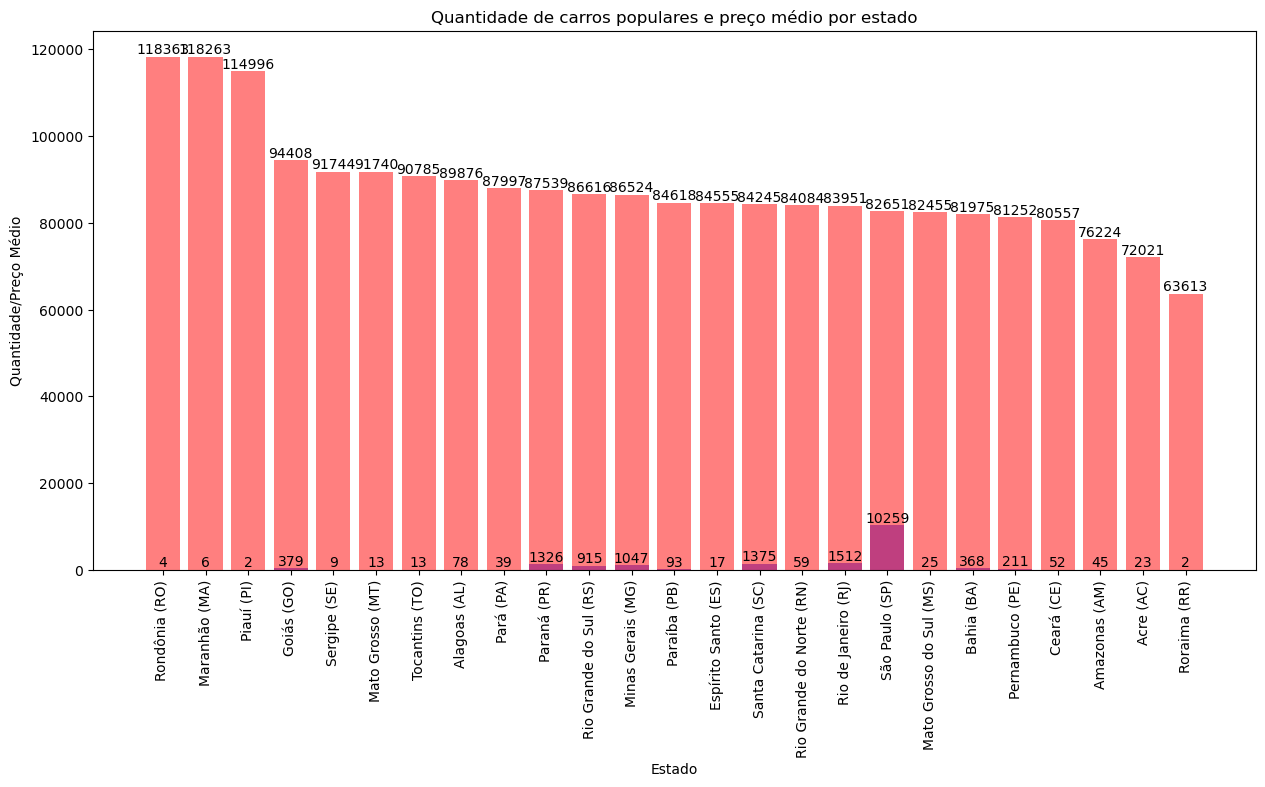

In [14]:
fig, ax = plt.subplots(figsize=(15, 7))

bar1 = ax.bar(df_popular_por_estado['sigla_estado'], df_popular_por_estado['quantidade'], color='b', alpha=0.5)
bar2 = ax.bar(df_popular_por_estado['sigla_estado'], df_popular_por_estado['media'], color='r', alpha=0.5)

ax.set_xlabel('Estado')
ax.set_ylabel('Quantidade/Preço Médio')
ax.set_title('Quantidade de carros populares e preço médio por estado')

plt.xticks(rotation=90)

autolabel(bar1)
autolabel(bar2)

plt.show()

In [15]:
fig = px.box(treino, x="estado_vendedor", y="preco", title='Boxplot dos preços dos veículos por estado')
fig.update_layout(autosize=False, width=1200, height=500)
fig.show()

- Resultado: São Paulo possui a maior quantidade de carros populares anunciados para venda comparado a outros estados presentes na base de dados. A alta oferta pode ser um grande atrativo para pessoas interessadas em uma variedade ampla de opções. O preço médio dos carros populares em São Paulo é relativamente alto em comparação  com outros estados, o que permite um melhor retorno financeiro. No cálculo do Índice de Desempenho, São Paulo teve o resultado mais alto dentre todos os estados com 0.739091, o que garante boa combinação de oferta (quantidade de carros anunciados) e demanda (preço médio relativamente alto).

## b Qual o melhor estado para se comprar uma picape com transmissão automática e por quê?

In [16]:
df_picape_automatico = treino[(treino['tipo'] == 'Picape') & (treino['cambio'] == 'Automática')]
df_picape_automatico.head(3)

id  num_fotos       marca  modelo  \
3    56862509826849933428086372390159405545       14.0  VOLKSWAGEN  AMAROK   
48  288950486904285252834098132344068709579        8.0  VOLKSWAGEN    GOLF   
61   35429253802991633165448719135914498665        8.0        FIAT    TORO   

                                               versao  ano_de_fabricacao  \
3   2.0 HIGHLINE 4X4 CD 16V TURBO INTERCOOLER DIES...               2013   
48        1.4 TSI HIGHLINE 16V GASOLINA 4P AUTOMÁTICO               2013   
61                       1.8 16V EVO FLEX FREEDOM AT6               2017   

    ano_modelo  hodometro      cambio  num_portas    tipo blindado     cor  \
3       2015.0    85357.0  Automática           4  Picape        N  Branco   
48      2015.0    61472.0  Automática           4  Picape        N  Branco   
61      2017.0   101623.0  Automática           4  Picape        N  Branco   

   tipo_vendedor cidade_vendedor estado_vendedor     anunciante  \
3             PJ        Sorocaba  São Paulo (SP)           Loja   
48            PF        Sorocaba  São Paulo (SP)  Pessoa Física   
61            PF       São Paulo  São Paulo (SP)  Pessoa Física   

    entrega_delivery  troca  elegivel_revisao  dono_aceita_troca  \
3               True   True             False                  1   
48             False  False             False                  0   
61             False  False             False                  1   

    veiculo_único_dono  revisoes_concessionaria  ipva_pago  \
3                    0                        0          1   
48                   0                        1          1   
61                   0                        0          0   

    veiculo_licenciado  garantia_de_fábrica  revisoes_dentro_agenda  \
3                    1                    0                       0   
48                   1                    0                       1   
61                   0                    0                       0   

    veiculo_alienado          preco popularidade  
3                  0  123681.358857      popular  
48                 0   86304.702755      popular  
61                 0   89522.637708      popular

In [17]:
media_preco_por_estado = df_picape_automatico.groupby('estado_vendedor')['preco'].mean()
media_preco_por_estado = media_preco_por_estado.sort_values()
media_preco_por_estado

estado_vendedor
Paraíba (PB)                 93157.035264
Mato Grosso do Sul (MS)     144700.247621
Acre (AC)                   145256.693656
Rio Grande do Norte (RN)    179961.694768
Rio de Janeiro (RJ)         181660.344685
Santa Catarina (SC)         185848.618546
Tocantins (TO)              187717.127524
São Paulo (SP)              188427.484638
Pernambuco (PE)             192566.764505
Rio Grande do Sul (RS)      195251.763134
Minas Gerais (MG)           195702.914796
Paraná (PR)                 198384.949644
Bahia (BA)                  206364.799217
Goiás (GO)                  208153.658437
Piauí (PI)                  208181.077756
Mato Grosso (MT)            214102.315642
Alagoas (AL)                218671.542780
Sergipe (SE)                298195.309673
Name: preco, dtype: float64

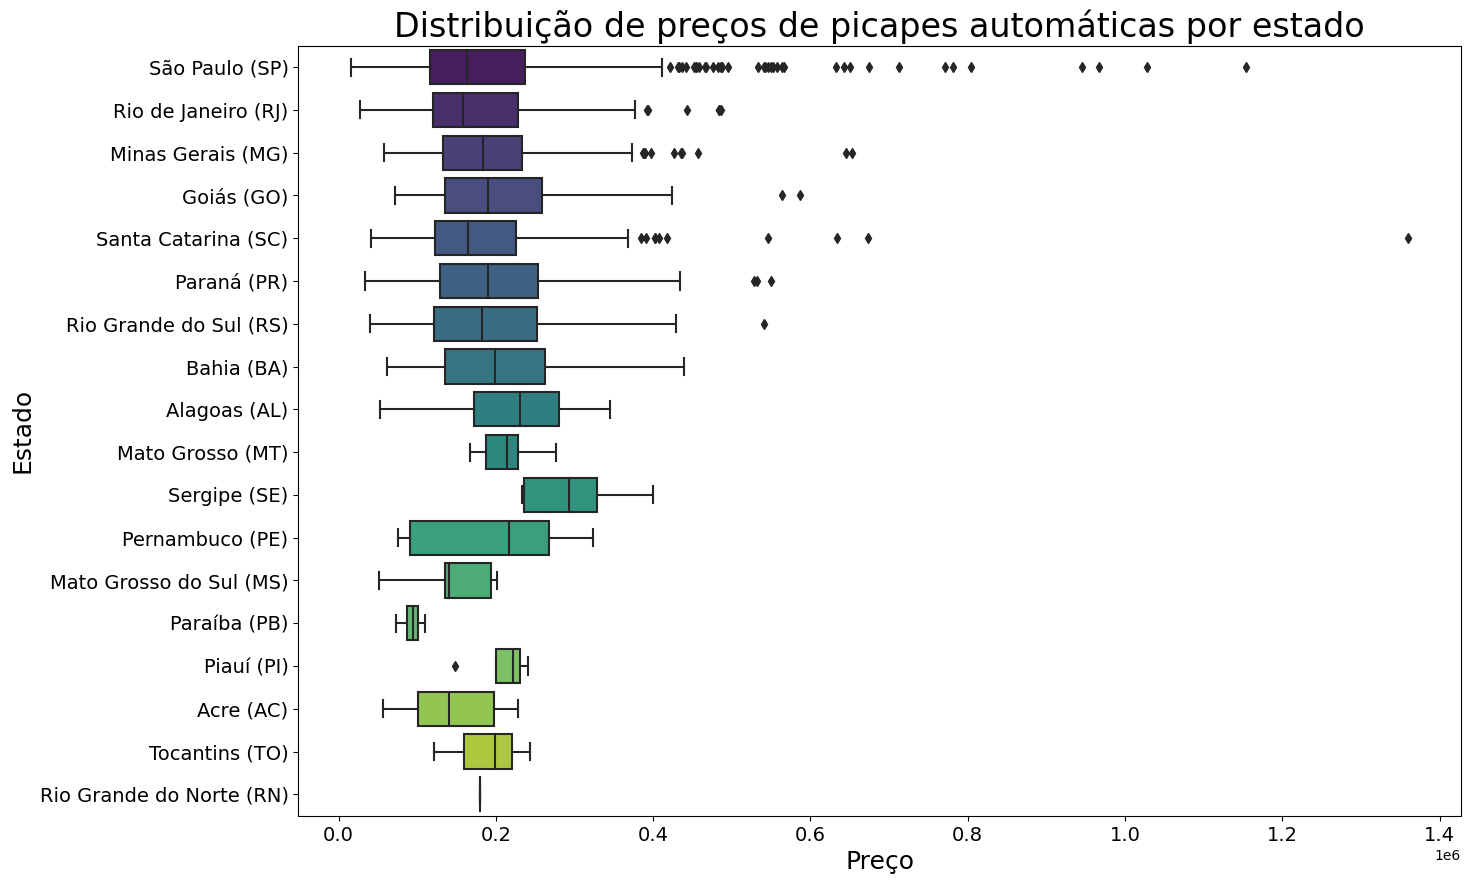

In [18]:
df_filtrado = treino[(treino['tipo'] == 'Picape') & (treino['cambio'] == 'Automática')]

plt.figure(figsize=(15,10))

sns.boxplot(data=df_filtrado, y='estado_vendedor', x='preco', palette='viridis')

plt.title('Distribuição de preços de picapes automáticas por estado', fontsize=24)
plt.xlabel('Preço', fontsize=18)
plt.ylabel('Estado', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [19]:
df_filtered = treino[(treino['tipo'] == 'Picape') & (treino['cambio'] == 'Automática')]
df_grouped = df_filtered.groupby('estado_vendedor').size()

df_agrupado = df_filtrado.groupby('estado_vendedor').size()
df_ordenado = df_agrupado.sort_values(ascending=False)

print(df_ordenado)

estado_vendedor
São Paulo (SP)              1712
Paraná (PR)                  348
Rio de Janeiro (RJ)          318
Santa Catarina (SC)          283
Minas Gerais (MG)            211
Rio Grande do Sul (RS)       198
Goiás (GO)                   102
Bahia (BA)                    68
Pernambuco (PE)               14
Alagoas (AL)                  12
Acre (AC)                      6
Mato Grosso (MT)               6
Mato Grosso do Sul (MS)        5
Sergipe (SE)                   5
Piauí (PI)                     4
Paraíba (PB)                   4
Tocantins (TO)                 3
Rio Grande do Norte (RN)       1
dtype: int64


In [20]:
df_filtrado = treino[(treino['tipo'] == 'Picape') & (treino['cambio'] == 'Automática')]
df_agrupado = df_filtrado.groupby('estado_vendedor').agg({'id': 'count', 'preco': 'mean'})
df_agrupado.columns = ['quantidade', 'preco_medio']
df_ordenado = df_agrupado.sort_values(by='preco_medio', ascending=False)

print(df_ordenado)

                          quantidade    preco_medio
estado_vendedor                                    
Sergipe (SE)                       5  298195.309673
Alagoas (AL)                      12  218671.542780
Mato Grosso (MT)                   6  214102.315642
Piauí (PI)                         4  208181.077756
Goiás (GO)                       102  208153.658437
Bahia (BA)                        68  206364.799217
Paraná (PR)                      348  198384.949644
Minas Gerais (MG)                211  195702.914796
Rio Grande do Sul (RS)           198  195251.763134
Pernambuco (PE)                   14  192566.764505
São Paulo (SP)                  1712  188427.484638
Tocantins (TO)                     3  187717.127524
Santa Catarina (SC)              283  185848.618546
Rio de Janeiro (RJ)              318  181660.344685
Rio Grande do Norte (RN)           1  179961.694768
Acre (AC)                          6  145256.693656
Mato Grosso do Sul (MS)            5  144700.247621
Paraíba (PB)

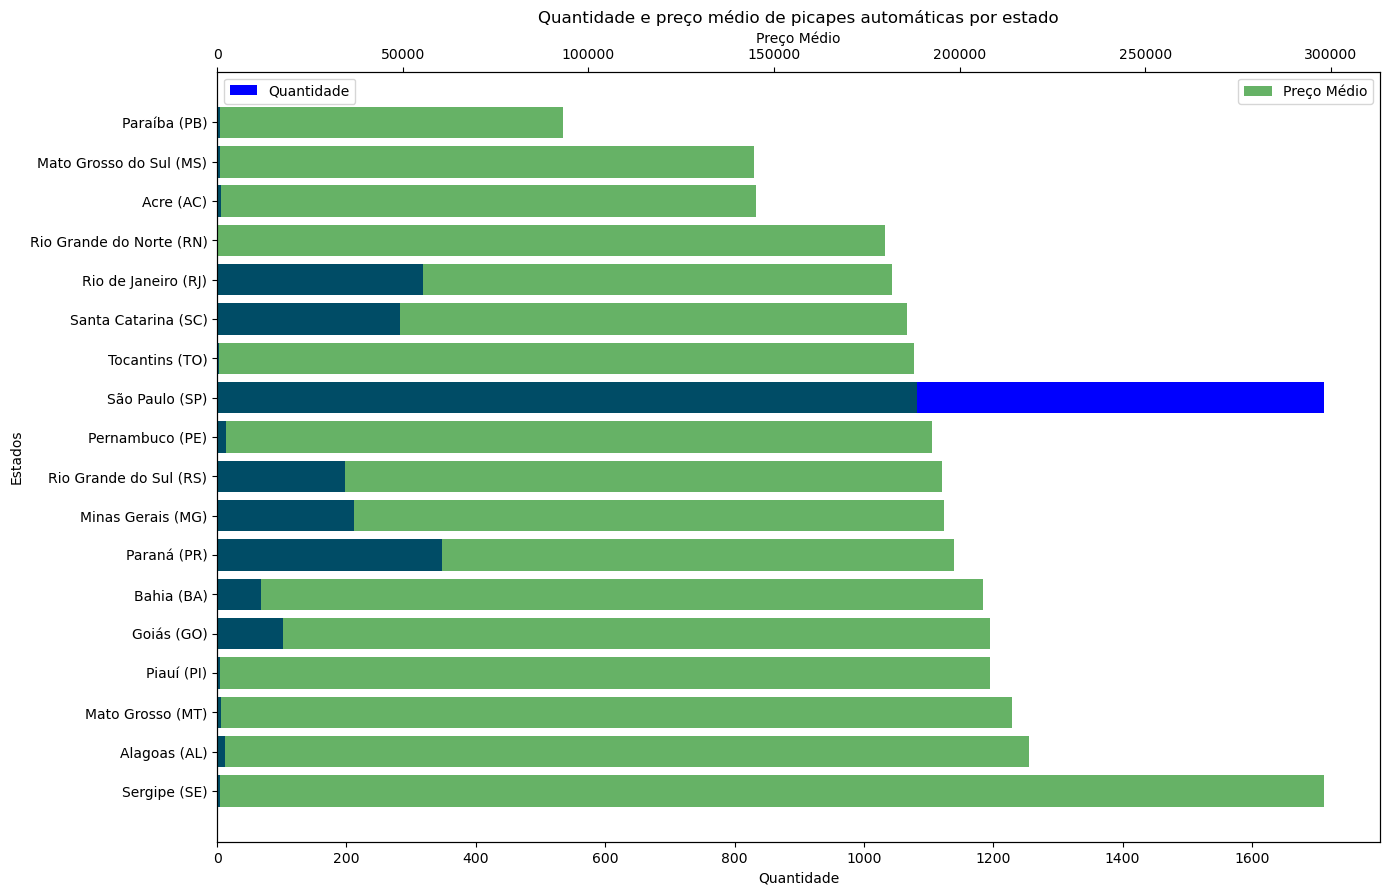

In [21]:
fig, ax1 = plt.subplots(figsize=(15, 10))

ax1.barh(df_ordenado.index, df_ordenado['quantidade'], color='blue', label='Quantidade')

ax2 = ax1.twiny()

ax2.barh(df_ordenado.index, df_ordenado['preco_medio'], color='green', label='Preço Médio', alpha=0.6)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax1.set_xlabel('Quantidade')
ax2.set_xlabel('Preço Médio')
ax1.set_ylabel('Estados')

plt.title('Quantidade e preço médio de picapes automáticas por estado')
plt.show()

In [22]:
resultados = treino.groupby('estado_vendedor').agg({
    'preco': ['median', 'count']
})

resultados.columns = ['preco_mediana', 'quantidade']

df_ordenado = resultados.sort_values(by='preco_mediana', ascending=True)

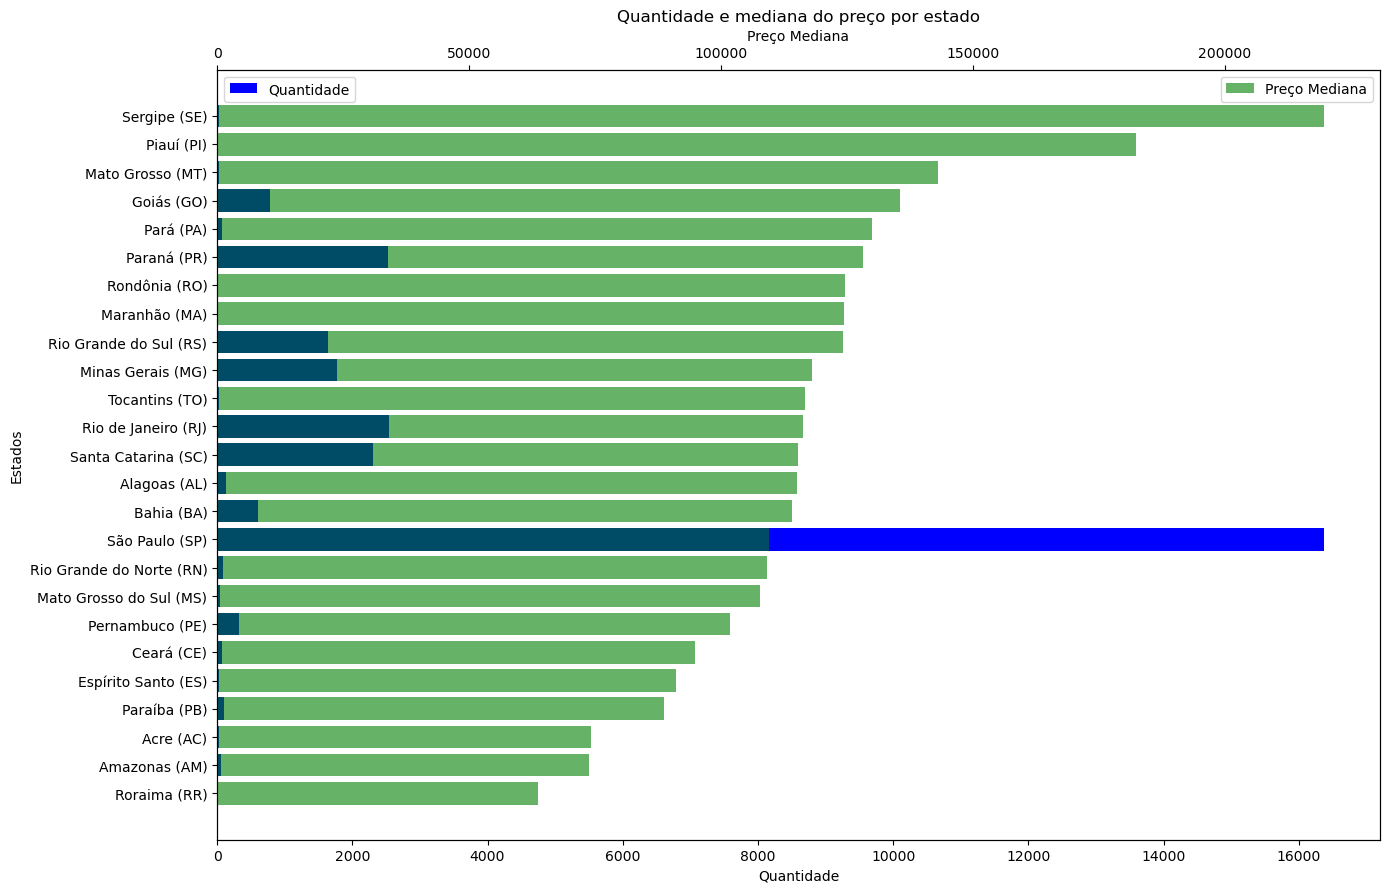

In [23]:
fig, ax1 = plt.subplots(figsize=(15, 10))

ax1.barh(df_ordenado.index, df_ordenado['quantidade'], color='blue', label='Quantidade')

ax2 = ax1.twiny()

ax2.barh(df_ordenado.index, df_ordenado['preco_mediana'], color='green', label='Preço Mediana', alpha=0.6)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax1.set_xlabel('Quantidade')
ax2.set_xlabel('Preço Mediana')
ax1.set_ylabel('Estados')

plt.title('Quantidade e mediana do preço por estado')
plt.show()

- Resposta: São Paulo foi considerado o melhor estado para compra de picapes automáticas. Com o preço médio aproximado de 188.427,48, fica em posição entre tods os estados porém se destaca potencialmente porque possui oferta significativa com 1712 unidades disponíveis, levando a uma competitivade de preços e variedade de escolha, fatores benéficos para compradores.

### c Qual o melhor estado para se comprar carros que ainda estejam dentro da garantia de fábrica e por quê?

In [24]:
carros_garantia = treino[treino['garantia_de_fábrica'] == True]
carros_garantia_por_estado = carros_garantia.groupby('estado_vendedor')
media_preco_por_estado = carros_garantia_por_estado['preco'].mean()

quantidade_carros_por_estado = carros_garantia_por_estado.size()

resultados = pd.DataFrame({
    'Media_Preco': media_preco_por_estado,
    'Quantidade_Carros': quantidade_carros_por_estado
})

resultados.sort_values(by=['Quantidade_Carros', 'Media_Preco'], ascending=[False, True], inplace=True)
print(resultados)

                            Media_Preco  Quantidade_Carros
estado_vendedor                                           
São Paulo (SP)            166751.081004               2307
Rio de Janeiro (RJ)       179109.858403                412
Paraná (PR)               175578.245503                389
Santa Catarina (SC)       173798.439853                330
Rio Grande do Sul (RS)    176442.236455                281
Minas Gerais (MG)         161206.273890                264
Goiás (GO)                174521.413156                186
Alagoas (AL)              154268.676544                 58
Bahia (BA)                165221.236199                 51
Pernambuco (PE)           149898.416932                 20
Pará (PA)                  98156.615283                 17
Mato Grosso do Sul (MS)   121709.589845                 13
Amazonas (AM)              99617.303347                  9
Espírito Santo (ES)       104030.208116                  9
Rio Grande do Norte (RN)  133120.393894                 

In [25]:
estados = resultados.index
quantidade_carros = resultados['Quantidade_Carros']
media_preco = resultados['Media_Preco']

quartiles = np.percentile(quantidade_carros, [25, 50, 75])
fig = go.Figure()

fig.add_trace(go.Bar(x=estados, y=quantidade_carros, name='Quantidade de Carros', marker_color='blue', opacity=0.6))

fig.add_trace(go.Bar(x=estados, y=media_preco, name='Preço Médio', marker_color='green', opacity=0.6, yaxis='y2'))

for quartile in quartiles:
    fig.add_shape(
        type="line",
        x0=estados[0], 
        x1=estados[-1],
        y0=quartile,
        y1=quartile,
        line=dict(color="red", width=1, dash="dash"),
        yref="y" 
    )

fig.update_layout(
    title='Quantidade de Carros e Preço Médio por Estado',
    xaxis_title='Estados',
    yaxis_title='Quantidade de Carros',
    yaxis2=dict(title='Preço Médio', overlaying='y', side='right'),
)
fig.show()


- Resposta: Minas Gerais (MG) destaca-se no cenário nacional, posicionando-se entre os 25% dos estados com maior volume de carros que ainda detêm garantia de fábrica. Este indicativo sugere uma preferência ou tendência do mercado mineiro em adquirir carros novos ou recentemente lançados, refletindo possivelmente a confiança dos consumidores na aquisição de veículos com garantias de fábrica, uma vez que essas garantias geralmente são indicativos de confiabilidade e segurança na compra.

## Modelagem

In [26]:
print("\nPercentual de valores nulos por coluna:")
print("---------------------------------------")
percentual_nulos = treino.isnull().mean() * 100
percentual_nulos


Percentual de valores nulos por coluna:
---------------------------------------


id                         0.000000
num_fotos                  0.598296
marca                      0.000000
modelo                     0.000000
versao                     0.000000
ano_de_fabricacao          0.000000
ano_modelo                 0.000000
hodometro                  0.000000
cambio                     0.000000
num_portas                 0.000000
tipo                       0.000000
blindado                   0.000000
cor                        0.000000
tipo_vendedor              0.000000
cidade_vendedor            0.000000
estado_vendedor            0.000000
anunciante                 0.000000
entrega_delivery           0.000000
troca                      0.000000
elegivel_revisao           0.000000
dono_aceita_troca          0.000000
veiculo_único_dono         0.000000
revisoes_concessionaria    0.000000
ipva_pago                  0.000000
veiculo_licenciado         0.000000
garantia_de_fábrica        0.000000
revisoes_dentro_agenda     0.000000
veiculo_alienado           0

In [27]:
print("\nPercentual de valores nulos por coluna:")
print("---------------------------------------")
percentual_nulos = teste.isnull().mean() * 100
percentual_nulos


Percentual de valores nulos por coluna:
---------------------------------------


id                         0.000000
num_fotos                  0.608396
marca                      0.000000
modelo                     0.000000
versao                     0.000000
ano_de_fabricacao          0.000000
ano_modelo                 0.000000
hodometro                  0.000000
cambio                     0.000000
num_portas                 0.000000
tipo                       0.000000
blindado                   0.000000
cor                        0.000000
tipo_vendedor              0.000000
cidade_vendedor            0.000000
estado_vendedor            0.000000
anunciante                 0.000000
entrega_delivery           0.000000
troca                      0.000000
elegivel_revisao           0.000000
dono_aceita_troca          0.000000
veiculo_único_dono         0.000000
revisoes_concessionaria    0.000000
ipva_pago                  0.000000
veiculo_licenciado         0.000000
garantia_de_fábrica        0.000000
revisoes_dentro_agenda     0.000000
veiculo_alienado           0

In [28]:
treino['Origem'] = 'treino'
teste['Origem'] = 'teste'
teste['preco'] = None
del treino['popularidade']

In [29]:
df = pd.concat([treino, teste])

In [30]:
df.head(3)

id  num_fotos   marca   modelo  \
0  300716223898539419613863097469899222392        8.0  NISSAN    KICKS   
1  279639842134129588306469566150288644214        8.0    JEEP  COMPASS   
2   56414460810621048900295678236538171981       16.0     KIA  SORENTO   

                                  versao  ano_de_fabricacao  ano_modelo  \
0        1.6 16V FLEXSTART SL 4P XTRONIC               2017      2017.0   
1        2.0 16V FLEX LIMITED AUTOMÁTICO               2017      2017.0   
2  2.4 16V GASOLINA EX 7L AWD AUTOMÁTICO               2018      2019.0   

   hodometro      cambio  num_portas  tipo blindado     cor tipo_vendedor  \
0    67772.0         CVT           4  Sedã        N  Branco            PF   
1    62979.0  Automática           4  Sedã        N  Branco            PF   
2    44070.0  Automática           4  Sedã        N   Preto            PJ   

  cidade_vendedor    estado_vendedor     anunciante  entrega_delivery  troca  \
0  Rio de Janeiro     São Paulo (SP)  Pessoa Física             False  False   
1  Belo Horizonte  Minas Gerais (MG)  Pessoa Física             False  False   
2          Santos     São Paulo (SP)           Loja              True  False   

   elegivel_revisao  dono_aceita_troca  veiculo_único_dono  \
0             False                  0                   0   
1             False                  1                   0   
2             False                  1                   0   

   revisoes_concessionaria  ipva_pago  veiculo_licenciado  \
0                        1          1                   1   
1                        0          1                   0   
2                        0          0                   0   

   garantia_de_fábrica  revisoes_dentro_agenda  veiculo_alienado  \
0                    0                       0                 0   
1                    0                       0                 0   
2                    0                       0                 0   

           preco  Origem  
0   74732.590084  treino  
1   81965.332634  treino  
2  162824.814472  treino

### Atribuindo a mediana aos valores nulos da coluna num_fotos (177 linhas nulas)

In [31]:
print("Contagem de valores na coluna 'num_fotos':")
print("-----------------------------------------")
print(df['num_fotos'].value_counts())

mediana = df['num_fotos'].median()
print("\nMediana da coluna 'num_fotos':", mediana)

df['num_fotos'] = df['num_fotos'].fillna(mediana)

print("\nInformações sobre o DataFrame 'treino':")
print("--------------------------------------")
df.info()

Contagem de valores na coluna 'num_fotos':
-----------------------------------------
8.0     25846
15.0     3725
16.0     2980
14.0     2412
17.0     1300
9.0       999
13.0      960
20.0      369
18.0      315
12.0      209
19.0       57
11.0       26
21.0        8
10.0        3
Name: num_fotos, dtype: int64

Mediana da coluna 'num_fotos': 8.0

Informações sobre o DataFrame 'treino':
--------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 39446 entries, 0 to 9861
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       39446 non-null  object 
 1   num_fotos                39446 non-null  float64
 2   marca                    39446 non-null  object 
 3   modelo                   39446 non-null  object 
 4   versao                   39446 non-null  object 
 5   ano_de_fabricacao        39446 non-null  int64  
 6   ano_modelo               394

## Hipóteses de negócio

In [32]:
df.describe()

num_fotos  ano_de_fabricacao    ano_modelo      hodometro  \
count  39446.000000       39446.000000  39446.000000   39446.000000   
mean      10.309867        2016.748137   2017.807154   58382.243371   
std        3.475235           4.084762      2.675334   32542.793054   
min        8.000000        1985.000000   1997.000000     100.000000   
25%        8.000000        2015.000000   2016.000000   31235.250000   
50%        8.000000        2018.000000   2018.000000   57244.500000   
75%       14.000000        2019.000000   2020.000000   81925.750000   
max       21.000000        2022.000000   2023.000000  390065.000000   

         num_portas  dono_aceita_troca  veiculo_único_dono  \
count  39446.000000       39446.000000        39446.000000   
mean       3.941135           0.741013            0.352330   
std        0.337210           0.438084            0.477702   
min        2.000000           0.000000            0.000000   
25%        4.000000           0.000000            0.000000   
50%        4.000000           1.000000            0.000000   
75%        4.000000           1.000000            1.000000   
max        4.000000           1.000000            1.000000   

       revisoes_concessionaria     ipva_pago  veiculo_licenciado  \
count             39446.000000  39446.000000        39446.000000   
mean                  0.310272      0.664782            0.538711   
std                   0.462611      0.472073            0.498506   
min                   0.000000      0.000000            0.000000   
25%                   0.000000      0.000000            0.000000   
50%                   0.000000      1.000000            1.000000   
75%                   1.000000      1.000000            1.000000   
max                   1.000000      1.000000            1.000000   

       garantia_de_fábrica  revisoes_dentro_agenda  veiculo_alienado  \
count         39446.000000            39446.000000           39446.0   
mean              0.146732                0.200350               0.0   
std               0.353843                0.400267               0.0   
min               0.000000                0.000000               0.0   
25%               0.000000                0.000000               0.0   
50%               0.000000                0.000000               0.0   
75%               0.000000                0.000000               0.0   
max               1.000000                1.000000               0.0   

              preco  
count  2.958400e+04  
mean   1.330239e+05  
std    8.166287e+04  
min    9.869951e+03  
25%    7.657177e+04  
50%    1.143558e+05  
75%    1.636796e+05  
max    1.359813e+06

### 1. Influência do Ano de Fabricação no Preço:
Hipótese: Veículos mais novos tendem a ter preços mais altos em comparação com os mais antigos. Especificamente, carros fabricados a partir de 2018 (mediana do ano de fabricação) podem ter um preço significativamente mais alto do que os fabricados antes desse ano.
Justificativa: Normalmente, carros mais novos possuem características e tecnologias mais atualizadas, maior eficiência no consumo de combustível, menos desgaste e, em muitos casos, ainda estão sob garantia, o que pode justificar preços mais elevados.

In [67]:
X = sm.add_constant(treino['ano_de_fabricacao'])

model = sm.OLS(treino['preco'], X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  preco   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     1795.
Date:                Fri, 21 Jul 2023   Prob (F-statistic):               0.00
Time:                        20:16:43   Log-Likelihood:            -3.7571e+05
No. Observations:               29584   AIC:                         7.514e+05
Df Residuals:                   29582   BIC:                         7.514e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -9.563e+06   2.29e+0

**Resultado**: O ano de fabricação tem uma relação positiva e estatisticamente significativa com o preço. No entanto, ele explica apenas **5,7%** da variabilidade do preço. Além disso, a análise sugere a presença de outliers e potencial multicolinearidade, o que pode impactar a confiabilidade do modelo.

### 2. Impacto do histórico de Manutenção no Preço:

Hipótese: Veículos que passaram por revisões na concessionária e têm todas as suas revisões dentro da agenda são vendidos a preços mais elevados do que aqueles que não têm um histórico de manutenção claro.
Justificativa: Revisões em concessionárias e manutenções programadas geralmente são vistas como indicadores de que o veículo foi bem cuidado. Compradores podem estar dispostos a pagar mais por carros que têm um histórico claro de manutenção, pois isso sugere que o carro pode ter menos problemas no futuro.

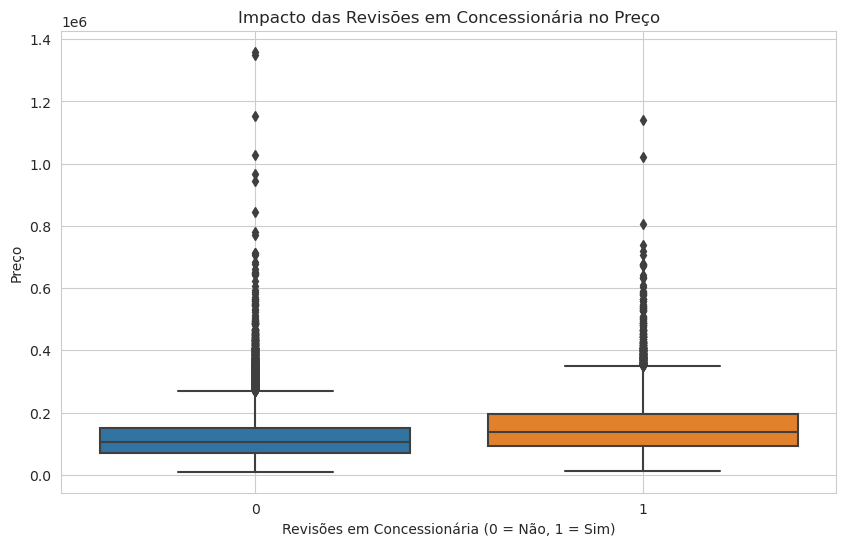

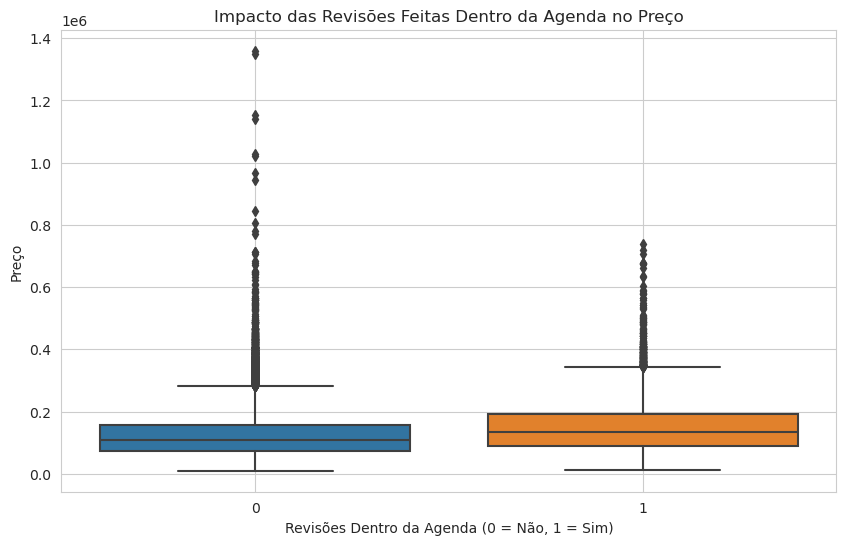

In [76]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='revisoes_concessionaria', y='preco', data=treino)
plt.title('Impacto das Revisões em Concessionária no Preço')
plt.xlabel('Revisões em Concessionária (0 = Não, 1 = Sim)')
plt.ylabel('Preço')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='revisoes_dentro_agenda', y='preco', data=treino)
plt.title('Impacto das Revisões Feitas Dentro da Agenda no Preço')
plt.xlabel('Revisões Dentro da Agenda (0 = Não, 1 = Sim)')
plt.ylabel('Preço')
plt.grid(True)
plt.show()

**Análise de revisões em concessionária:**

Mediana (Valor Central)

    Sem Revisão: 105.42k
    Com Revisão: 136.21k

Há uma diferença notável na mediana dos preços entre os dois grupos. Os carros com revisões em concessionárias possuem uma mediana 30.79k maior, indicando que o valor central dos carros revisados em concessionárias tende a ser mais elevado.

Quartis (Dispersão dos Preços)

    O Q1 (primeiro quartil) para carros com revisão é 20.46k mais alto, sugerindo que os 25% mais baratos dos carros com revisão em concessionária ainda são vendidos a preços mais elevados em comparação com os sem essa revisão.
    O Q3 (terceiro quartil) para carros com revisão é 40.56k maior. Isso significa que, até mesmo nos segmentos de preços mais altos, os carros com revisões em concessionárias ainda são negociados a valores superiores.

Limites (Extremos dos Preços)

    O preço mínimo para carros com revisão é maior por 3.71k.
    O preço máximo para carros com revisão é menor por 219.7k. Este é um ponto interessante e poderia indicar que carros sem revisão em concessionárias, mas talvez com características especiais ou raridades, alcançam valores muito elevados no mercado.
    
**Análise de Revisão dentro da agenda**: Mediana (Valor Central)

    Sem Revisão: 109.73k
    Com Revisão: 134.59k

Observando as medianas, os carros com revisões feitas dentro da agenda têm uma mediana de preço 22.86k mais alta que os carros sem essas revisões. Isso indica que o valor central dos carros com revisões programadas é mais alto.
O Q1 (primeiro quartil) para carros com revisões é 15.83k maior, indicando que 25% dos carros com revisões têm um preço acima de 89.73k, enquanto aqueles sem revisão têm preços acima de 73.90k.
Curiosamente, o preço máximo para carros com revisão é significativamente menor (619.913k a menos). No entanto, é importante lembrar que outliers ou valores extremos podem ser influenciados por outros fatores, não apenas pela revisão.

### 3. Relação entre o Número de Fotos e o Preço:

Hipótese: Veículos que possuem um número de fotos acima da média (mais do que 10, que é a média fornecida) são vendidos a preços mais elevados do que os que possuem menos fotos.
Justificativa: Um número maior de fotos pode indicar que o vendedor está mais engajado em vender o carro e está fornecendo detalhes abrangentes sobre o veículo. Isso pode transmitir mais confiança ao comprador potencial, permitindo que o vendedor defina um preço mais alto. Adicionalmente, veículos com características ou condições especiais (como interiores de alta qualidade ou customizações) podem ter mais fotos para destacar esses atributos.

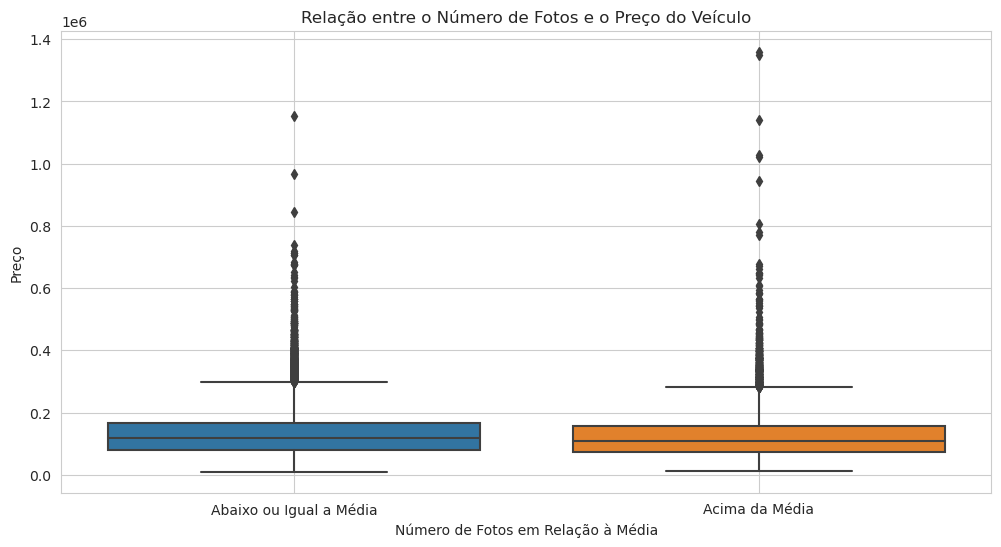

In [73]:
treino['fotos_acima_media'] = treino['num_fotos'].apply(lambda x: 'Acima da Média' if x > 10 else 'Abaixo ou Igual a Média')

plt.figure(figsize=(12, 6))
sns.boxplot(x='fotos_acima_media', y='preco', data=treino, order=['Abaixo ou Igual a Média', 'Acima da Média'])
plt.title('Relação entre o Número de Fotos e o Preço do Veículo')
plt.xlabel('Número de Fotos em Relação à Média')
plt.ylabel('Preço')
plt.grid(True)
plt.show()


**Análise Relação entre o número de fotos e o preço do veículo:**
- Mediana: Veículos com fotos abaixo ou igual à média têm uma mediana de preço mais alta (117.74k) em comparação com aqueles com fotos acima da média (107.15k).
- Dispersion: A dispersão de preços (Q3 - Q1) é ligeiramente maior para veículos com fotos abaixo ou igual à média.
- Valores extremos: Enquanto veículos com mais fotos têm um valor máximo mais elevado (1.359813M vs 1.15436M), veículos com menos fotos apresentam uma mediana de preço mais elevada.


Contrário à hipótese inicial, veículos com um número de fotos abaixo ou igual à média tendem a ter preços medianos ligeiramente mais elevados do que aqueles com fotos acima da média. Embora possa parecer surpreendente à primeira vista, essa descoberta sugere que simplesmente ter mais fotos não é um forte indicativo de um preço mais alto.

In [33]:
map_dict = {True: 1, False: 0}

df['entrega_delivery'] = df['entrega_delivery'].map(map_dict)
print("\nContagem de 'entrega_delivery':")
print(df['entrega_delivery'].value_counts())

df['troca'] = df['troca'].map(map_dict)
print("\nContagem de 'troca':")
print(df['troca'].value_counts())

df['elegivel_revisao'] = df['elegivel_revisao'].map(map_dict)
print("\nContagem de 'elegivel_revisao':")
print(df['elegivel_revisao'].value_counts())

df = df.drop('elegivel_revisao', axis=1)

map_dict_tipo_vendedor = {'PF': 1, 'PJ': 0}
df['tipo_vendedor'] = df['tipo_vendedor'].map(map_dict_tipo_vendedor)
print("\nContagem de 'tipo_vendedor':")
print(df['tipo_vendedor'].value_counts())

map_dict_blindado = {'S': 1, 'N': 0}
df['blindado'] = df['blindado'].map(map_dict_blindado)
print("\nContagem de 'blindado':")
print(df['blindado'].value_counts())

print("\nContagem de 'tipo':")
print(df['tipo'].value_counts())

print("\nContagem de 'anunciante':")
print(df['anunciante'].value_counts())

print("\nContagem de 'marca':")
print(df['marca'].value_counts())


Contagem de 'entrega_delivery':
0    31508
1     7938
Name: entrega_delivery, dtype: int64

Contagem de 'troca':
0    32740
1     6706
Name: troca, dtype: int64

Contagem de 'elegivel_revisao':
0    39446
Name: elegivel_revisao, dtype: int64

Contagem de 'tipo_vendedor':
1    23857
0    15589
Name: tipo_vendedor, dtype: int64

Contagem de 'blindado':
0    39128
1      318
Name: blindado, dtype: int64

Contagem de 'tipo':
Sedã                    21910
Hatchback                6570
Picape                   6426
Utilitário esportivo     4458
Perua/SW                   37
Cupê                       34
Minivan                    10
Conversível                 1
Name: tipo, dtype: int64

Contagem de 'anunciante':
Pessoa Física                       23949
Loja                                13182
Concessionária                       2310
Acessórios e serviços para autos        5
Name: anunciante, dtype: int64

Contagem de 'marca':
VOLKSWAGEN       6140
CHEVROLET        4020
TOYOTA           

In [34]:
df.columns

Index(['id', 'num_fotos', 'marca', 'modelo', 'versao', 'ano_de_fabricacao',
       'ano_modelo', 'hodometro', 'cambio', 'num_portas', 'tipo', 'blindado',
       'cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor',
       'anunciante', 'entrega_delivery', 'troca', 'dono_aceita_troca',
       'veiculo_único_dono', 'revisoes_concessionaria', 'ipva_pago',
       'veiculo_licenciado', 'garantia_de_fábrica', 'revisoes_dentro_agenda',
       'veiculo_alienado', 'preco', 'Origem'],
      dtype='object')

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39446 entries, 0 to 9861
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       39446 non-null  object 
 1   num_fotos                39446 non-null  float64
 2   marca                    39446 non-null  object 
 3   modelo                   39446 non-null  object 
 4   versao                   39446 non-null  object 
 5   ano_de_fabricacao        39446 non-null  int64  
 6   ano_modelo               39446 non-null  float64
 7   hodometro                39446 non-null  float64
 8   cambio                   39446 non-null  object 
 9   num_portas               39446 non-null  int64  
 10  tipo                     39446 non-null  object 
 11  blindado                 39446 non-null  int64  
 12  cor                      39446 non-null  object 
 13  tipo_vendedor            39446 non-null  int64  
 14  cidade_vendedor        

### Correlação

In [36]:
df_numeric = df.query("Origem == 'treino'").select_dtypes(exclude=['object'])

corr_matrix = df_numeric.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

corr_masked = corr_matrix.mask(mask)

fig = ff.create_annotated_heatmap(
    reversescale=True,
    z=corr_masked.to_numpy(),
    x=list(corr_masked.columns),
    y=list(corr_masked.index),
    annotation_text=corr_masked.round(2).to_numpy(),
    colorscale='Viridis',
    showscale=True
)
fig.show()

In [37]:
df = df.drop('veiculo_alienado', axis=1)

## Modelo Baseline

In [38]:
df_numeric = df.select_dtypes(exclude=['object'])

# Selecionando as colunas para avaliar
features = list(df_numeric.columns)
features.remove('preco')  # Removendo 'preco' da lista

# Preparando os dados
X = df.query("Origem == 'treino'")[features]
y = df.query("Origem == 'treino'")['preco']

In [39]:
%%time
models = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor(n_estimators=100, random_state=0)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=0)),
    ('SVR', SVR()),
    ('Decision Tree', DecisionTreeRegressor()),
    ('Ridge Regression', Ridge()),
    ('Lasso Regression', Lasso()),
    ('ElasticNet Regression', ElasticNet()),
    ('KNN', KNeighborsRegressor()),
    ('XGBoost', XGBRegressor(random_state=0)),
    ('LightGBM', LGBMRegressor(random_state=0)),
    ('AdaBoost', AdaBoostRegressor(random_state=0))  
]

scoring = {
    'rmse': make_scorer(lambda y, y_pred: mean_squared_error(y, y_pred, squared=False)),
    'mae': make_scorer(mean_absolute_error),
    'r2': make_scorer(r2_score)
}

results = {}
for name, model in models:
    results.update(evaluate_model(X, y, model, name))

for metric, values in results.items():
    print(f"{metric}: {values.mean()} +/- {values.std()}")

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 23667, number of used features: 16
[LightGBM] [Info] Start training from score 133134.160023
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 347
[LightGBM] [Info] Number of data points in the train set: 23667, number of used features: 16
[LightGBM] [Info] Start training from score 132950.826942
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if me

## Criando novas Features

### País 'fabricante' de cada marca 

In [40]:
fabricante = {
    "VOLKSWAGEN": "Alemanha",
    "CHEVROLET": "EUA",
    "TOYOTA": "Japão",
    "HYUNDAI": "Coreia do Sul",
    "JEEP": "EUA",
    "FIAT": "Itália",
    "BMW": "Alemanha",
    "AUDI": "Alemanha",
    "PEUGEOT": "França",
    "HONDA": "Japão",
    "MERCEDES-BENZ": "Alemanha",
    "FORD": "EUA",
    "MITSUBISHI": "Japão",
    "LAND ROVER": "Reino Unido",
    "RENAULT": "França",
    "NISSAN": "Japão",
    "KIA": "Coreia do Sul",
    "PORSCHE": "Alemanha",
    "VOLVO": "Suécia",
    "CITROËN": "França",
    "TROLLER": "Brasil",
    "RAM": "EUA",
    "CHERY": "China",
    "JAGUAR": "Reino Unido",
    "MINI": "Reino Unido",
    "LEXUS": "Japão",
    "SUZUKI": "Japão",
    "SUBARU": "Japão",
    "DODGE": "EUA",
    "CHRYSLER": "EUA",
    "SSANGYONG": "Coreia do Sul",
    "SMART": "Alemanha",
    "ALFA ROMEO": "Itália",
    "LIFAN": "China",
    "MASERATI": "Itália",
    "JAC": "China",
    "IVECO": "Itália",
    "EFFA": "China",
    "FERRARI": "Itália",
    "LAMBORGHINI": "Itália",
    "BRM": "Brasil"
}

In [41]:
df['fabricante'] = df['marca'].map(fabricante)
print(df['modelo'].value_counts())

COMPASS    1967
2008       1924
Q3         1213
TORO       1179
COROLLA    1168
           ... 
ML 320        1
ES 350        1
STILO         1
RS7           1
M 140i        1
Name: modelo, Length: 473, dtype: int64


### Feature 'motor' criada a partir da extração da coluna versão indicando a capacidade do motor

In [42]:
df['motor'] = df['versao'].apply(capacidade_motor_cilindradas)
df['motor'] = df['motor'].astype(float)
df['motor'] = df['motor'].fillna(0)

In [43]:
df['valvulas'] = df['versao'].apply(capacidade_motor_valvulas)
df['valvulas'] = df['valvulas'].astype(float)
df['valvulas'] = df['valvulas'].fillna(0)

df['capacidade_motor'] = df['valvulas']*df['motor']

In [44]:
df['alimentacao'] = df['versao'].apply(extract_fuel_type)

In [45]:
categorical_columns = ['cambio', 'tipo', 'cor', 'tipo_vendedor', 'anunciante', 
                       'marca', 'modelo', 'cidade_vendedor', 'estado_vendedor', 'versao', 
                       'fabricante', 'alimentacao']
df_dummies = df.copy()

for column in categorical_columns:
    dummies = pd.get_dummies(df[column], prefix=column)
    df_dummies = pd.concat([df_dummies, dummies], axis=1)
    df_dummies = df_dummies.drop(column, axis=1)    

In [46]:
df_numeric = df_dummies.select_dtypes(exclude=['object'])

In [47]:
%%time
features = list(df_numeric.columns)
features.remove('preco')  

X = df_dummies.query("Origem == 'treino'")[features]
y = df_dummies.query("Origem == 'treino'")['preco']

y = np.log(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.columns = [col.replace(" ", "_") for col in X_train.columns]
X_val.columns = [col.replace(" ", "_") for col in X_val.columns]
X_train = X_train.fillna(0)
y_train = y_train.fillna(0)
X_val = X_val.fillna(0)

model = LGBMRegressor(random_state=0, force_col_wise=True)
model.fit(X_train, y_train.ravel())

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

y_pred_train = np.exp(y_pred_train)
y_pred_val = np.exp(y_pred_val)

y_train = np.exp(y_train)
y_val = np.exp(y_val)

print("Train Set Evaluation:")
print(f"RMSE: {mean_squared_error(y_train, y_pred_train, squared=False)}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train)}")
print(f"R2: {r2_score(y_train, y_pred_train)}")

print("Validation Set Evaluation:")
print(f"RMSE: {mean_squared_error(y_val, y_pred_val, squared=False)}")
print(f"MAE: {mean_absolute_error(y_val, y_pred_val)}")
print(f"R2: {r2_score(y_val, y_pred_val)}")

std_dev = np.std(y_pred_val)

print(f'Standard Deviation of predictions: {std_dev}')

[LightGBM] [Info] Total Bins 1505
[LightGBM] [Info] Number of data points in the train set: 23667, number of used features: 544
[LightGBM] [Info] Start training from score 11.637752
Train Set Evaluation:
RMSE: 39925.16580360189
MAE: 24733.842725292197
R2: 0.763834239930197
Validation Set Evaluation:
RMSE: 39822.37622314718
MAE: 25912.022047000297
R2: 0.7500548577222276
Standard Deviation of predictions: 68229.65705494708
CPU times: user 4.19 s, sys: 1.59 s, total: 5.78 s
Wall time: 3.95 s


In [48]:
df.columns

Index(['id', 'num_fotos', 'marca', 'modelo', 'versao', 'ano_de_fabricacao',
       'ano_modelo', 'hodometro', 'cambio', 'num_portas', 'tipo', 'blindado',
       'cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor',
       'anunciante', 'entrega_delivery', 'troca', 'dono_aceita_troca',
       'veiculo_único_dono', 'revisoes_concessionaria', 'ipva_pago',
       'veiculo_licenciado', 'garantia_de_fábrica', 'revisoes_dentro_agenda',
       'preco', 'Origem', 'fabricante', 'motor', 'valvulas',
       'capacidade_motor', 'alimentacao'],
      dtype='object')

### 3.Explique como você faria a previsão do preço a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?

Eu faço a previsão do preço utilizando as variáveis preditoras () e com feature engeneering aprimorei o resultado do modelo criando novas variáveis, assim, tornando melhor explicáveis para o modelo as regras obtidas.
A previsão hoje está sendo feita através de modelos de árvores de decisão, modelos de boosting (explicar).
Variáeis utilizadas e transformações:
 Certamente! Vou descrever cada uma das colunas para você:

1. **num_fotos**: Número de fotos do veículo. Foi atribuída a mediana a fim de tratar os 177 nulos da coluna.

2. **marca**: Marca do veículo. Com base na coluna foi criada a nova Feature chamada "fabricante", utilizando o país de fabricação do veículo. A coluna marca foi transformada em dummy.

3. **modelo**: Modelo do veículo. Foi transformada em dummy.

4. **versao**: Variação específica do modelo. Foi utilizada para criar as novas Features "alimentacao", "motor", "valvulas", "capacidade_motor".

5. **ano_de_fabricacao**: Ano em que o veículo foi produzido. Foi utilizada por ter moderada correlação com o target "preço". A medida que aumenta o ano de fabricação, o preço também aumenta.

6. **ano_modelo**: Ano do design/modelo do veículo. Foi utilizada por ter  correlação moderada positiva com o target "preço".

7. **hodometro**: Distância total percorrida pelo veículo. Correlação moderada negativa, a medida que o preço aumenta, o hodômetro diminui.


8. **cambio**: Tipo de transmissão do veículo. Utilizada como dummy.

9. **num_portas**: Número de portas do veículo. Foi utilizada.

10. **tipo**: Categoria do veículo. Foi utilizada como dummy.

11. **blindado**: Indica se o veículo possui blindagem ou não. Foi utilizada.

12. **cor**: Cor externa do veículo. Foi utilizada como dummy.

13. **tipo_vendedor**: Pode indicar se o vendedor é um indivíduo (particular) ou um estabelecimento comercial (loja, concessionária, etc.). Foi utilizada como dummy.

14. **cidade_vendedor**: Cidade onde o vendedor está localizado. Foi utilizada como dummy.

15. **estado_vendedor**: Estado onde o vendedor está localizado. Foi utilizada como dummy.

16. **anunciante**: Nome ou identificação do anunciante. Foi utilizada como dummy.

17. **entrega_delivery**: Indica se o vendedor oferece entrega do veículo via delivery. Foi utilizada.

18. **troca**: Se o vendedor está aberto a trocar o veículo por outro item ou veículo. Foi utilizada.

19. **dono_aceita_troca**: Se o dono atual aceita uma troca por outro veículo ou item. Foi utilizada.

20. **veiculo_único_dono**: Indica se o veículo teve apenas um proprietário anterior. Foi utilizada.

21. **revisoes_concessionaria**: Se o veículo passou por revisões feitas em concessionárias autorizadas. Foi utilizada.

22. **ipva_pago**: Indica se o IPVA (Imposto sobre a Propriedade de Veículos Automotores) do veículo está em dia.

23. **veiculo_licenciado**: Se o veículo está licenciado e legal para ser dirigido.

24. **garantia_de_fábrica**: Indica se o veículo ainda está sob a garantia original de fábrica.

25. **revisoes_dentro_agenda**: Se todas as revisões do veículo foram realizadas dentro do cronograma recomendado.

26. **preco**: Preço pedido pelo vendedor pelo veículo. Variável target.

27. **Origem**: Criado provisoriamente para indicar a origem da separação de treino e teste.

Fizemos um comparativo entre diversos modelos de regressão, e o modelo que trouxe um resultado melhor esperado foi o LightGBM ele foi projetado para ser eficiente com grandes conjuntos de dados e distribuição de dados desequilibrados. Como prós ele é rápido no treinamento e eficiente em memória, possui parâmetros embutidos para lidar com dados desequilibrados, o fator negativo pode ser o overfitting em pequenos datasets e a interpretabilidade, já que é baseado em boosting de árvores (árvores combinadas).
Usando a métrica MAE-Mean Absolute Error" que mede a média das diferenças absolutas entre as previsões e os valores observados.


In [49]:
X_test = df_dummies.query("Origem == 'teste'")[features]
X_test.columns = [col.replace(" ", "_") for col in X_test.columns]
X_test = X_test.fillna(0)

y_pred_test = model.predict(X_test)

y_pred_test = np.exp(y_pred_test)

print("Test Set Predictions:")
print(y_pred_test)

Test Set Predictions:
[ 74536.55432974  76330.08863499 251326.98271018 ...  99772.67236452
 122615.14923741 264502.87674497]


In [50]:
len(y_pred_test)

9862

In [51]:
len(df_dummies.query("Origem == 'teste'")['id'])

9862

In [52]:
previsao = pd.DataFrame()
previsao['id'] = df_dummies.query("Origem == 'teste'")['id']
previsao['preco'] = np.array(y_pred_test)
previsao.to_csv('predicted.csv')